In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.datasets import make_classification
from sklearn.naive_bayes import MultinomialNB
from mimic_calibration import _MimicCalibration

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
n_samples = 1000
X, y = make_classification(n_samples=3 * n_samples, n_features=6,random_state=42)
X -= X.min()
X_train, y_train = X[:n_samples], y[:n_samples]
X_calib, y_calib = X[n_samples:2 * n_samples], y[n_samples:2 * n_samples]
clf = MultinomialNB().fit(X_train, y_train)
y_calib_score = clf.predict_proba(X_calib)
y_calib_score = np.array([ score[1] for score in y_calib_score])

In [4]:
print(y_calib[:10])
print(y_calib_score[:10])

[1 0 0 1 1 1 1 1 0 0]
[0.72519729 0.56204016 0.37790463 0.61490316 0.70866065 0.62202329
 0.5139929  0.66173912 0.31795471 0.48888974]


In [5]:
mimicObject = _MimicCalibration(threshold_pos=5, record_history=True)
mimicObject.fit(y_calib_score, y_calib)

_MimicCalibration(record_history=True, threshold_pos=5)

In [6]:
y_mimic_calib_score = mimicObject.predict(y_calib_score)

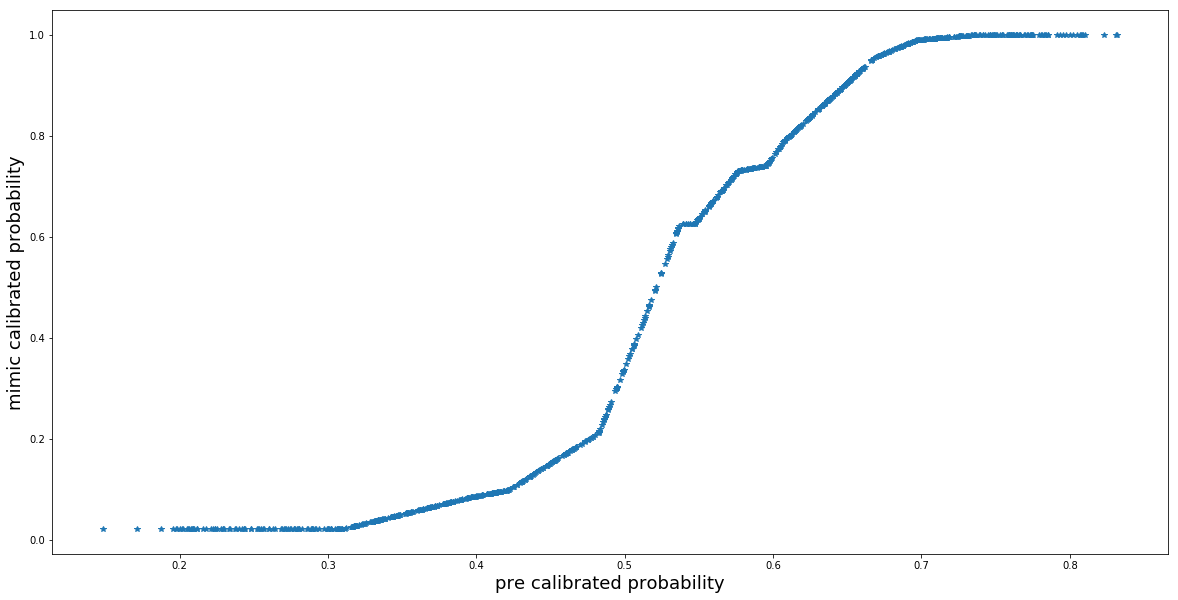

In [7]:
fig = plt.figure()
plt.plot(y_calib_score,y_mimic_calib_score, "*")
plt.xlabel("pre calibrated probability", fontsize=18)
plt.ylabel("mimic calibrated probability", fontsize=18)
fig.savefig("mimic_calib_prob.png")

plot history size: 20


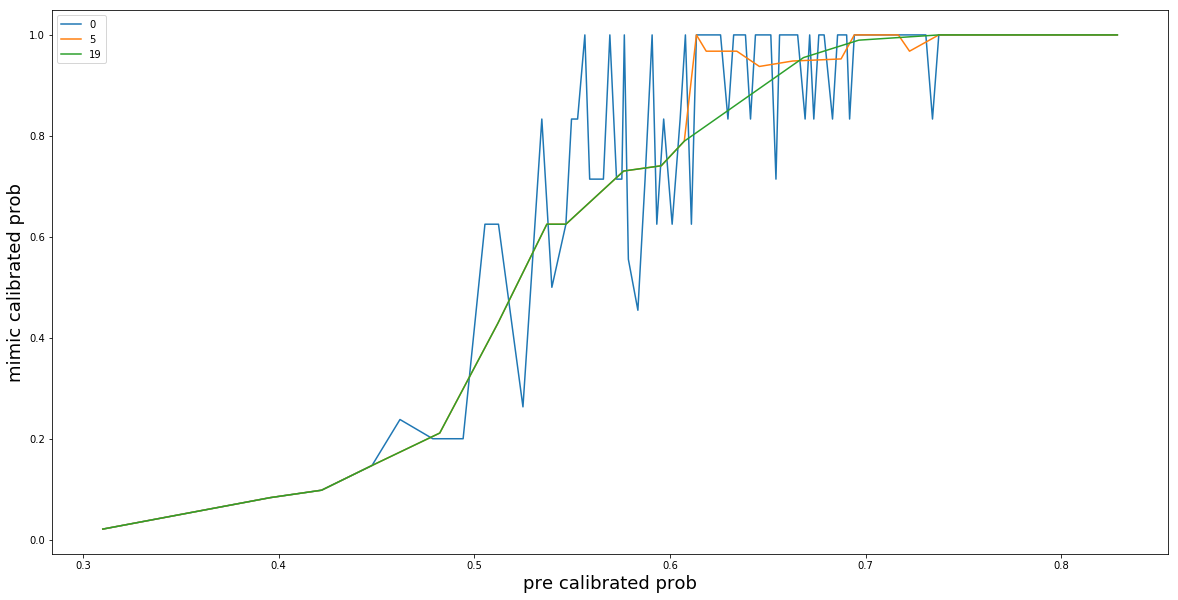

In [8]:
history = mimicObject.history_record_table
mimicObject.plot_history_result([0, 5, 19])